In [207]:
# def simulate_dynamic_path(n_days, start_price, initial_regime, brain, bins,
#                           thresholds, jitter=0.001, zero_threshold=1e-5, span=390):
#     """
#     Simulates price path using Rolling EWMA Volatility for regime switching.
#     """
#     minutes_per_day = 390
#     all_returns = []

#     current_ret = 0.0
#     current_regime = initial_regime

#     # --- 1. INITIALIZE ROLLING MEMORY ---
#     # Formula: Var = (Threshold / sqrt(390))^2
#     alpha = 2 / (span + 1) # EWMA decay factor

#     # Estimate starting volatility based on initial regime
#     if initial_regime == 'extreme': start_vol = thresholds['extreme']
#     elif initial_regime == 'high':  start_vol = thresholds['high']
#     elif initial_regime == 'low':   start_vol = thresholds['low']
#     else:                           start_vol = (thresholds['low'] + thresholds['high']) / 2

#     # Initialize running variance
#     current_ewma_var = (start_vol / np.sqrt(390)) ** 2

#     for day in range(n_days):

#         # Load Brain
#         regime_data = brain.get(current_regime, brain.get('high', brain['normal']))
#         buckets = regime_data['buckets']
#         stds = regime_data['stds']

#         day_returns = np.zeros(minutes_per_day)

#         for m in range(minutes_per_day):
#             state = np.digitize(current_ret, bins) - 1
#             state = max(0, min(state, len(bins) - 2))

#             if state in buckets:
#                 choices = buckets[state]
#             else:
#                 choices = brain['normal']['buckets'].get(state, [0.0])

#             sampled = choices[np.random.randint(len(choices))]

#             # Zero-Lock & Jitter
#             if abs(sampled) < zero_threshold:
#                 current_ret = 0.0
#             else:
#                 noise = np.random.normal(0, stds.get(state, 0) * jitter)
#                 current_ret = sampled + noise

#             day_returns[m] = current_ret

#             # --- 2. UPDATE ROLLING MEMORY (Minute by Minute) ---
#             # Var_t = alpha * r_t^2 + (1 - alpha) * Var_{t-1}
#             current_ewma_var = alpha * (current_ret**2) + (1 - alpha) * current_ewma_var

#         all_returns.extend(day_returns)

#         # --- 3. CHECK REGIME (End of Day) ---
#         # Calculate 'Daily Equivalent' Volatility from our running variance
#         simulated_daily_vol = np.sqrt(current_ewma_var) * np.sqrt(390)

#         # Switch Regime based on this smoothed metric
#         current_regime = get_next_regime(simulated_daily_vol, thresholds)

#     price_path = start_price * np.cumprod(1 + np.array(all_returns))
#     return np.insert(price_path, 0, start_price)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [77]:
%cd /content/drive/MyDrive/Simulation/

/content/drive/MyDrive/Simulation


In [331]:
import os
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from statsmodels.tsa.stattools import adfuller

import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle
from scipy.stats import gaussian_kde
from scipy.stats import kurtosis
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import ks_2samp

from matplotlib.backends.backend_pdf import PdfPages
import scipy.stats as stats

**Report Function**

In [354]:
def create_market_report(sim_df, real_segment, start_date, end_date, parameters, output_file="Simulation_Report.pdf"):
    print(f"Generating Comprehensive Report: {start_date} to {end_date}...")

    if len(real_segment) != len(sim_df):
        print(f"Error: Length mismatch. Real={len(real_segment)}, Sim={len(sim_df)}")
        return

    # --- 1. CALCULATE METRICS ---
    real_log_returns = pd.Series(np.diff(np.log(real_segment)))
    sim_log_returns_df = pd.DataFrame(np.diff(np.log(sim_df), axis=0), columns=sim_df.columns)
    all_sim_returns_flat = sim_log_returns_df.values.flatten()

    stats_dict = {}
    stats_dict['Real Vol'] = np.std(real_log_returns)
    stats_dict['Sim Vol'] = np.mean(np.std(sim_log_returns_df, axis=0))
    stats_dict['Real Kurt'] = kurtosis(real_log_returns)
    stats_dict['Sim Kurt'] = kurtosis(all_sim_returns_flat)

    # VaR & CVaR (99%)
    stats_dict['Real VaR'] = np.percentile(real_log_returns, 1)
    stats_dict['Sim VaR'] = np.percentile(all_sim_returns_flat, 1)
    stats_dict['Real CVaR'] = real_log_returns[real_log_returns <= stats_dict['Real VaR']].mean()
    stats_dict['Sim CVaR'] = all_sim_returns_flat[all_sim_returns_flat <= stats_dict['Sim VaR']].mean()

    # Drawdowns
    try:
        stats_dict['Real MDD'] = get_max_drawdown(real_segment)
        sim_mdds = [get_max_drawdown(sim_df[c].values) for c in sim_df.columns]
        stats_dict['Sim MDD Avg'] = np.mean(sim_mdds)
    except:
        stats_dict['Real MDD'] = 0.0; stats_dict['Sim MDD Avg'] = 0.0

    # KS Test
    ks_stat, p_value = ks_2samp(real_log_returns, all_sim_returns_flat)
    stats_dict['KS P-Val'] = p_value

    # Final Z-Score
    sim_means = sim_df.mean(axis=1)
    sim_stds = sim_df.std(axis=1)
    stats_dict['Final Z-Score'] = (real_segment[-1] - sim_means.iloc[-1]) / (sim_stds.iloc[-1] + 1e-8)

    # --- 2. GENERATE FIGURES ---
    figures = []

    # FIG 1: Summary & Appendix
    fig0, ax0 = plt.subplots(figsize=(8.5, 11))
    ax0.axis('off')

    # Header
    text_str = f"MARKOV SHADOW SIMULATION REPORT\n"
    text_str += f"Period: {start_date} to {end_date}\n"
    text_str += "="*45 + "\n\n"

    # Key Metrics
    text_str += f"VOLATILITY ENERGY:\n"
    text_str += f"  Real Vol: {stats_dict['Real Vol']:.6f}\n  Sim Vol:  {stats_dict['Sim Vol']:.6f}\n"
    text_str += f"  (Ratio: {stats_dict['Sim Vol']/stats_dict['Real Vol']:.2f}x)\n\n"

    text_str += f"TAIL RISK (CRASH CAPTURE):\n"
    text_str += f"  Real VaR (99%): {stats_dict['Real VaR']:.4%}\n  Sim VaR (99%):  {stats_dict['Sim VaR']:.4%}\n"
    text_str += f"  Real CVaR:      {stats_dict['Real CVaR']:.4%}\n  Sim CVaR:       {stats_dict['Sim CVaR']:.4%}\n\n"

    text_str += f"DISTRIBUTION & DRAWDOWN:\n"
    text_str += f"  Real Kurtosis: {stats_dict['Real Kurt']:.2f}\n  Sim Kurtosis:  {stats_dict['Sim Kurt']:.2f}\n"
    text_str += f"  Real MDD: {stats_dict['Real MDD']:.2%}\n  Sim Avg MDD: {stats_dict['Sim MDD Avg']:.2%}\n\n"

    text_str += f"HEALTH CHECK:\n"
    text_str += f"  Final Z-Score: {stats_dict['Final Z-Score']:.2f}\n"
    text_str += f"  KS Test P-Val: {stats_dict['KS P-Val']:.4f}\n\n"

    # --- APPENDIX SECTION ---
    text_str += "="*45 + "\n"
    text_str += "APPENDIX: MODEL PARAMETERS\n"
    text_str += "="*45 + "\n"
    for key, value in parameters.items():
        text_str += f"  {key}: {value}\n"

    ax0.text(0.1, 0.95, text_str, fontsize=11, family='monospace', verticalalignment='top')
    figures.append(fig0)

    # FIG 2: Fan Chart
    fig1, ax1 = plt.subplots(figsize=(10, 6))
    sim_median = sim_df.median(axis=1)
    sim_upper = sim_df.quantile(0.95, axis=1)
    sim_lower = sim_df.quantile(0.05, axis=1)
    ax1.fill_between(range(len(sim_median)), sim_lower, sim_upper, color='gray', alpha=0.2, label='90% Conf')
    ax1.plot(sim_median, color='blue', linestyle='--', label='Sim Median')
    ax1.plot(real_segment, color='red', lw=2, label='Real Price')
    ax1.set_title(f"Price Alignment: {start_date} to {end_date}")
    ax1.legend()
    figures.append(fig1)

    # FIG 3: Instant Z-Score
    fig2, ax2 = plt.subplots(figsize=(10, 6))
    sim_ret_means = sim_log_returns_df.mean(axis=1)
    sim_ret_stds = sim_log_returns_df.std(axis=1)
    z_scores = (real_log_returns.values - sim_ret_means.values) / (sim_ret_stds.values + 1e-8)
    ax2.plot(z_scores, color='purple', alpha=0.3, lw=0.5)
    rolling_z = pd.Series(z_scores).rolling(60).mean()
    ax2.plot(rolling_z, color='black', lw=1.5, label='Rolling Bias')
    ax2.axhline(3, color='red', linestyle='--'); ax2.axhline(-3, color='red', linestyle='--')
    ax2.set_title("Return Z-Scores (Volatility Stress Test)")
    ax2.set_ylim(-8, 8)
    figures.append(fig2)

    # FIG 4: QQ Plot
    fig3, ax3 = plt.subplots(figsize=(8, 8))
    sorted_real = np.sort(real_log_returns)
    sampled_sim = np.random.choice(all_sim_returns_flat, size=len(sorted_real), replace=False)
    sorted_sim = np.sort(sampled_sim)
    ax3.scatter(sorted_real, sorted_sim, alpha=0.5, color='#2980b9', s=10)
    lims = [np.min([ax3.get_xlim(), ax3.get_ylim()]), np.max([ax3.get_xlim(), ax3.get_ylim()])]
    ax3.plot(lims, lims, 'r-', alpha=0.75, lw=2)
    ax3.set_title('Q-Q Plot: Tail Alignment')
    ax3.grid(True, alpha=0.3)
    figures.append(fig3)

    # SAVE
    with PdfPages(output_file) as pdf:
        for fig in figures:
            pdf.savefig(fig)
            plt.close(fig)
    print(f"Report saved to: {output_file}")

**Stat Related Functions**

In [309]:
def check_volatility_clustering(real_rets, sim_df, lags=30):
    # Absolute returns highlight the 'magnitude' of the move
    real_abs = np.abs(real_rets)
    # Average absolute returns across all paths for a global model check
    sim_abs = np.abs(sim_df.pct_change().dropna()).mean(axis=1)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    plot_acf(real_abs, lags=lags, ax=ax[0], title="Real Volatility Clustering")
    plot_acf(sim_abs, lags=lags, ax=ax[1], title="Simulated Volatility Clustering")
    plt.show()

In [310]:
def calculate_hurst(price_path):
    """Calculates the Hurst Exponent to check for long-term memory."""
    lags = range(2, 100)
    # Calculate the variance of the difference between price points at different lags
    tau = [np.sqrt(np.std(np.subtract(price_path[lag:], price_path[:-lag]))) for lag in lags]

    # Use a linear fit to find the power-law relationship
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    return poly[0] * 2.0

In [311]:
def get_max_drawdown(path):
    rolling_max = np.maximum.accumulate(path)
    drawdowns = (path - rolling_max) / rolling_max
    return np.min(drawdowns)

In [312]:
def test_leverage_effect(returns):
    """Checks if negative returns lead to higher subsequent volatility."""
    abs_returns = np.abs(returns[1:])
    lagged_returns = returns[:-1]
    correlation = np.corrcoef(lagged_returns, abs_returns)[0, 1]
    return correlation

In [313]:
def volatility_persistence(returns, threshold_quantile=0.95):
    """Measures how long high-volatility events tend to last."""
    threshold = np.quantile(np.abs(returns), threshold_quantile)
    is_volatile = np.abs(returns) > threshold

    # Count consecutive True values (persistence)
    persistence = []
    count = 0
    for v in is_volatile:
        if v: count += 1
        else:
            if count > 0: persistence.append(count)
            count = 0
    return np.mean(persistence) if persistence else 0

In [314]:
def check_zero_frequency(returns, label, threshold = 1e-9):
    # Defining 'zero' as moves smaller than 1e-7 to account for float precision
    zeros = np.sum(np.abs(returns) < threshold)
    total = len(returns)
    freq = (zeros / total) * 100
    print(f"{label} Zero-Return Frequency: {freq:.2f}%")
    return freq

**Data Processing Functions**

In [315]:
def calculate_daily_volatility(price_series, span=390):
    """
    Calculates Daily Volatility using Intraday EWMA (Rolling 1-Day).
    Captures Overnight Gaps and Intraday Chaos.
    """
    # 1. Log Returns (Captures the Overnight Gap at 9:30 automatically)
    # epsilon is added to avoid log(0) errors if price doesn't change
    log_rets = np.log(price_series / price_series.shift(1))

    # 2. EWMA Variance (Span = 390 minutes = 1 Trading Day)
    # We track Variance first, then Sqrt later
    ewma_var = log_rets.pow(2).ewm(span=span, adjust=False).mean()

    # 3. Convert to Annualized-like Daily Volatility Scale
    # We multiply by sqrt(390) to make it comparable to 'Daily % Returns'
    ewma_vol_daily = np.sqrt(ewma_var) * np.sqrt(390)

    # 4. Resample to Daily (Take the volatility at Market Close)
    return ewma_vol_daily.resample('D').last().dropna()

In [316]:
def label_regimes(daily_vol_series, thresholds):
    """
    Classifies days into 'low', 'normal', 'high', 'extreme'.
    """
    def get_label(vol):
        if pd.isna(vol): return 'normal'

        if vol > thresholds['extreme']: return 'extreme'

        if vol > thresholds['high']: return 'high'

        if vol < thresholds['low']: return 'low'

        return 'normal'

    return daily_vol_series.apply(get_label)

In [317]:
def align_regimes_to_minutes(minute_data, daily_labels):
    """Merges the daily regime label into the minute-level dataset."""
    minute_data = minute_data.copy()
    minute_data['date_only'] = minute_data.index.normalize()

    # We map YESTERDAY'S volatility to TODAY'S minutes
    # This simulates the "morning" state of the market
    shifted_labels = daily_labels.shift(1).to_frame(name='regime')

    merged = minute_data.merge(shifted_labels, left_on='date_only', right_index=True, how='left')
    merged['regime'] = merged['regime'].fillna('normal') # Default for start of history
    return merged

**Simulation Related Functions**

In [318]:
def build_state_map(data_subset, threshold_zero=1e-5):
    """
    Extracts the transition logic (next returns) for a single regime.
    """
    # Create next_return column if it doesn't exist
    if 'next_return' not in data_subset.columns:
        data_subset = data_subset.copy()
        data_subset['next_return'] = data_subset.groupby('date_only')['return'].shift(-1)

    # Apply Zero-Lock Threshold
    data_subset.loc[data_subset['next_return'].abs() < threshold_zero, 'next_return'] = 0.0

    # Map State -> List of Returns
    state_map = (data_subset.dropna(subset=['next_return', 'state'])
                 .groupby('state')['next_return']
                 .apply(list).to_dict())
    return state_map

In [319]:
def optimize_regime_library(raw_maps, bins, tail_percentile=0.05):
    """
    Converts raw return lists into optimized Pre-Sampled Buckets (KDE/Empirical).
    Returns a 'Brain' dictionary ready for fast simulation.
    """
    optimized_brain = {}
    num_bins = len(bins) - 1

    # Identify tail bins indices
    tail_count = int(num_bins * tail_percentile)
    tail_indices = set(list(range(tail_count)) + list(range(num_bins - tail_count, num_bins)))

    for regime_name, state_map in raw_maps.items():
        buckets = {}
        stds = {}

        for state, rets in state_map.items():
            arr = np.array(rets)
            stds[state] = np.std(arr)

            # DECISION: KDE or Empirical?
            # Use KDE for middle states with sufficient data (>50 points)
            if state not in tail_indices and len(arr) > 50:
                try:
                    kde = gaussian_kde(arr)
                    # Pre-sample 10,000 points for speed
                    buckets[state] = kde.resample(10000).flatten()
                except:
                    buckets[state] = arr # Fallback to empirical if KDE fails
            else:
                buckets[state] = arr # Keep tails raw to preserve kurtosis

        optimized_brain[regime_name] = {'buckets': buckets, 'stds': stds}

    return optimized_brain

In [320]:
def get_next_regime(daily_return, thresholds):
    """Decides tomorrow's regime based on today's simulated volatility."""
    vol = abs(daily_return)

    if vol > thresholds['extreme']: return 'extreme'
    if vol > thresholds['high']:    return 'high'
    if vol < thresholds['low']:     return 'low'

    return 'normal'

In [321]:
def simulate_dynamic_path(sim_schedule, start_price, initial_regime, brain, bins,
                          thresholds, jitter=0.001, zero_threshold=1e-5, span=390):
    """
    Simulates intraday price paths using the Exact Real Schedule.
    sim_schedule: List of tuples [(gap_log_return, minutes_in_day), ...]
    """
    price_path = [start_price]
    current_price = start_price
    current_regime = initial_regime

    # Initialize Volatility Memory
    alpha = 2 / (span + 1)
    if initial_regime == 'extreme': start_vol = thresholds['extreme']
    elif initial_regime == 'high':  start_vol = thresholds['high']
    elif initial_regime == 'low':   start_vol = thresholds['low']
    else:                           start_vol = (thresholds['low'] + thresholds['high']) / 2

    current_ewma_var = (start_vol / np.sqrt(390)) ** 2

    # Iterate through the REAL Schedule (Day by Day)
    for day_idx, (gap_ret, minutes_in_day) in enumerate(sim_schedule):

        # --- A. MORNING SHOCK (Gap) ---
        current_price *= np.exp(gap_ret)
        current_ewma_var = alpha * (gap_ret**2) + (1 - alpha) * current_ewma_var

        # Determine Open Regime
        morning_vol = np.sqrt(current_ewma_var) * np.sqrt(390)
        current_regime = get_next_regime(morning_vol, thresholds)

        # --- B. INTRADAY SIMULATION (Dynamic Length) ---
        regime_data = brain.get(current_regime, brain.get('high', brain['normal']))
        buckets = regime_data['buckets']
        stds = regime_data['stds']

        current_ret = 0.0

        # CRITICAL CHANGE: We simulate exactly 'minutes_in_day' (e.g., 384 or 210)
        for m in range(minutes_in_day):
            state = np.digitize(current_ret, bins) - 1
            state = max(0, min(state, len(bins) - 2))

            if state in buckets:
                choices = buckets[state]
            else:
                choices = brain['normal']['buckets'].get(state, [0.0])

            sampled = choices[np.random.randint(len(choices))]

            if abs(sampled) < zero_threshold:
                current_ret = 0.0
            else:
                noise = np.random.normal(0, stds.get(state, 0) * jitter)
                current_ret = sampled + noise

            current_price *= np.exp(current_ret)
            price_path.append(current_price)

            current_ewma_var = alpha * (current_ret**2) + (1 - alpha) * current_ewma_var

        # --- C. END OF DAY ---
        daily_vol_proxy = np.sqrt(current_ewma_var) * np.sqrt(390)
        current_regime = get_next_regime(daily_vol_proxy, thresholds)

    return np.array(price_path)

**Simulation Start**

In [322]:
# 1. LOAD & PREPARE
data = pd.read_parquet('Intraday_Clean_Data/VOO_clean_intraday_2010_2025.parquet')
data = data.sort_index() # Ensure time order

In [460]:
# --- USER CONFIGURATION ---
simulation_start_date = '2025-03-06'  # YYYY-MM-DD
lookback_years = 6                    # Training window (e.g., 2018-2023)
n_days_to_simulate = 11               # Trading days to simulate

# Model Params
EWMA_SPAN = 390
REGIME_THRESHOLDS = {
    'low': 0.004,      # < 0.4%
    'high': 0.015,     # > 1.2%
    'extreme': 0.025   # > 2.5%
}
TAIL_PERCENTILE = 0.05
ZERO_THRESH = 1e-5
JITTER = 0.001
N_SIMULATIONS = 200

In [461]:
# --- AUTOMATIC TRAINING WINDOW ---
sim_start_dt = pd.Timestamp(simulation_start_date).normalize()
cutoff_date = sim_start_dt - pd.DateOffset(years=lookback_years)

# Filter Training Data (Strictly BEFORE simulation start)
training_data = data[(data.index >= cutoff_date) & (data.index < sim_start_dt)].copy()
print(f"Training Data Range: {training_data.index.min()} to {training_data.index.max()}")

Training Data Range: 2019-03-06 09:31:00 to 2025-03-05 16:00:00


In [462]:
# Calculate Regimes
daily_vol = calculate_daily_volatility(data['Close'], span=EWMA_SPAN)
daily_labels = label_regimes(daily_vol, REGIME_THRESHOLDS)
training_data = align_regimes_to_minutes(training_data, daily_labels)

In [463]:
# 2. BUILD BINS
custom_quantiles = [0, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25,
                    0.4, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99, 0.999, 0.9999, 1.0]
bin_edges = np.unique(training_data['return'].quantile(custom_quantiles).values)
training_data['state'] = pd.cut(training_data['return'], bins=bin_edges, labels=False, include_lowest=True)

In [464]:
# 3. BUILD THE BRAIN
raw_library = {}
unique_regimes = training_data['regime'].unique()

print("Training Markov Regimes...")
for r in unique_regimes:
    subset = training_data[training_data['regime'] == r]
    raw_library[r] = build_state_map(subset, threshold_zero=ZERO_THRESH)
    print(f" - Regime '{r}': {len(subset)} minutes trained.")

simulation_brain = optimize_regime_library(raw_library, bin_edges, tail_percentile=TAIL_PERCENTILE)

Training Markov Regimes...
 - Regime 'normal': 463724 minutes trained.
 - Regime 'low': 77252 minutes trained.
 - Regime 'high': 35486 minutes trained.
 - Regime 'extreme': 9694 minutes trained.


In [465]:
# --- 6. RUN SIMULATION ---

# A. Locate the specific days to simulate
sim_data = data[data.index >= sim_start_dt].copy()
sim_dates = np.unique(sim_data.index.date)[:n_days_to_simulate]

print(f"Simulating {len(sim_dates)} days starting {sim_dates[0]}...")

# B. Build the 'Simulation Schedule'
# We extract: (1) The Gap, and (2) The EXACT number of minutes for that day
sim_schedule = []
start_loc = data.index.get_loc(data[data.index.date == sim_dates[0]].index[0])

for d in sim_dates:
    day_slice = data[data.index.date == d]
    if len(day_slice) == 0: continue

    # 1. Calculate Gap
    first_min_idx = data.index.get_loc(day_slice.index[0])
    prev_close_price = data['Close'].iloc[first_min_idx - 1]
    today_open_price = data['Close'].iloc[first_min_idx]
    gap = np.log(today_open_price / prev_close_price)

    # 2. Count Minutes (The "Shadow" Logic)
    minutes_in_day = len(day_slice)

    sim_schedule.append((gap, minutes_in_day))

# C. Anchor Price
anchor_price = data['Close'].iloc[start_loc - 1]
anchor_date = data.index[start_loc - 1].normalize()
initial_regime = daily_labels.get(anchor_date, 'normal')

# D. Run Loop
print(f"Schedule Prepared. Day 1: Gap={sim_schedule[0][0]:.2%}, Mins={sim_schedule[0][1]}")

sim_results = []
for i in range(N_SIMULATIONS):
    if i%20==0:
      print("Entering Simulation Number:", i,".")
    path = simulate_dynamic_path(
        sim_schedule=sim_schedule,
        start_price=anchor_price,
        initial_regime=initial_regime,
        brain=simulation_brain,
        bins=bin_edges,
        thresholds=REGIME_THRESHOLDS,
        jitter=JITTER,
        zero_threshold=ZERO_THRESH,
        span=EWMA_SPAN
    )
    sim_results.append(path)

# E. Align Results
sim_df = pd.DataFrame(sim_results).T

Simulating 11 days starting 2025-03-06...
Schedule Prepared. Day 1: Gap=-1.40%, Mins=390
Entering Simulation Number: 0 .
Entering Simulation Number: 20 .
Entering Simulation Number: 40 .
Entering Simulation Number: 60 .
Entering Simulation Number: 80 .
Entering Simulation Number: 100 .
Entering Simulation Number: 120 .
Entering Simulation Number: 140 .
Entering Simulation Number: 160 .
Entering Simulation Number: 180 .


**Fan Chart**

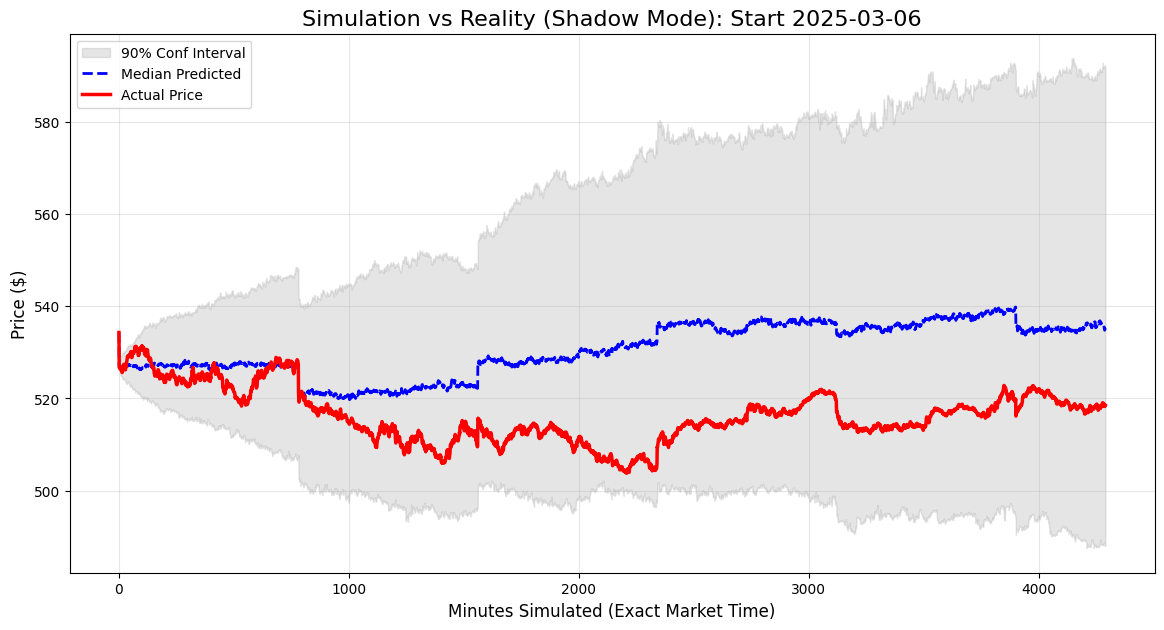

In [466]:
# 5. VISUALIZATION (Perfect Alignment)
sim_median = sim_df.median(axis=1)
sim_upper_95 = sim_df.quantile(0.95, axis=1)
sim_lower_05 = sim_df.quantile(0.05, axis=1)

# Extract Real Data
# Because we simulated exactly 'len(day_slice)' for each day,
# len(sim_df) is guaranteed to equal len(real_segment) if we slice continuously.
req_length = len(sim_median)
real_segment = data['Close'].iloc[start_loc - 1 : start_loc - 1 + req_length].values

plt.figure(figsize=(14, 7))
plt.fill_between(range(len(sim_median)), sim_lower_05, sim_upper_95,
                 color='gray', alpha=0.2, label='90% Conf Interval')
plt.plot(sim_median, color='blue', lw=2, label='Median Predicted', linestyle='--')

if len(real_segment) == len(sim_median):
    plt.plot(real_segment, color='red', lw=2.5, label='Actual Price')
else:
    print(f"Warning: Length Mismatch! Sim={len(sim_median)}, Real={len(real_segment)}")
    # Fallback plotting if future data is missing
    plt.plot(real_segment, color='red', lw=2.5, label='Actual Price (Partial)')

plt.title(f"Simulation vs Reality (Shadow Mode): Start {sim_start_dt.date()}", fontsize=16)
plt.xlabel("Minutes Simulated (Exact Market Time)", fontsize=12)
plt.ylabel("Price ($)", fontsize=12)
plt.legend(loc='upper left')
plt.grid(alpha=0.3)
plt.show()

**Statistical Test**


--- STATISTICAL VALIDATION REPORT ---


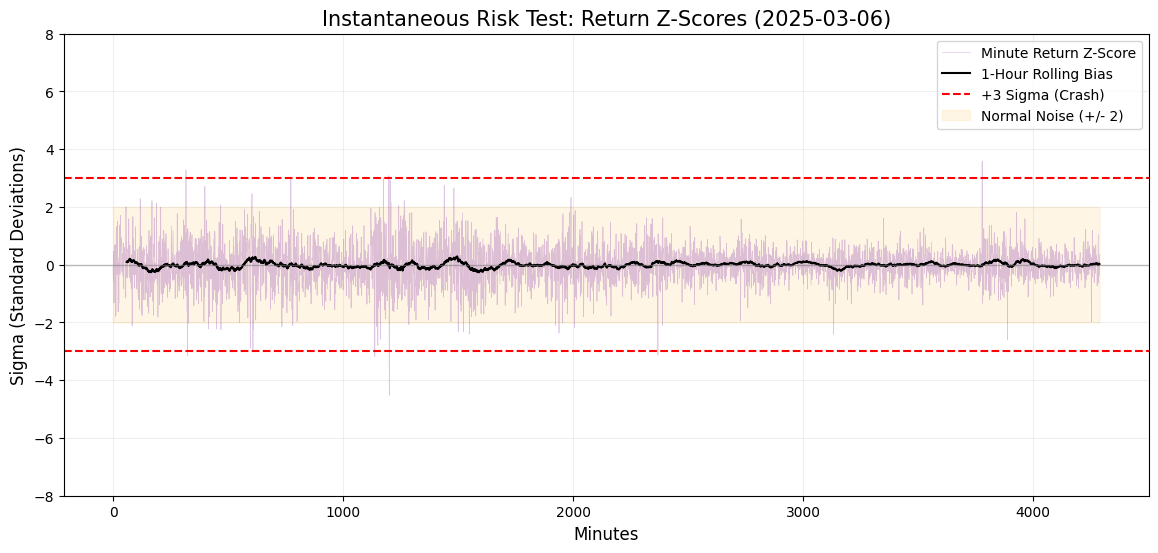

Z-Score Dispersion: 0.67 (Target ~1.0. >1.2 means Real Market is wilder than Sim)
Volatility | Real: 0.000691 vs Sim: 0.000971
Kurtosis   | Real: 83.13 vs Sim: 34.26
Hurst      | Real: 0.489 vs Sim: 0.492


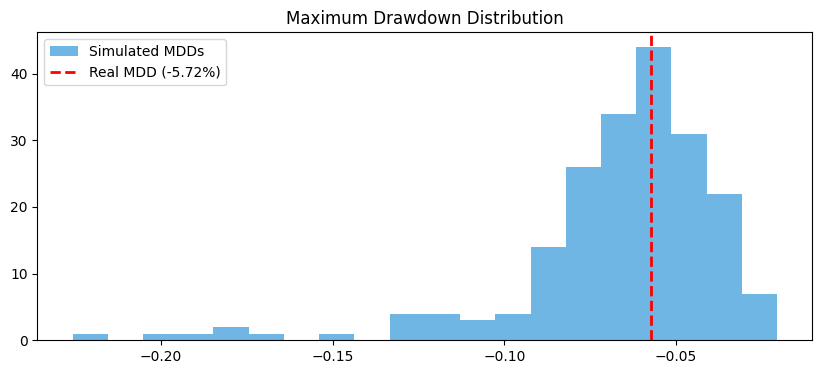

KS Test    | Stat: 0.0597, P-Value: 0.0000
Result: FAIL (Significant Difference)


In [467]:
# --- 5. STATISTICAL VALIDATION (Dynamic & Corrected) ---

# Check if we have real data to compare against
if len(real_segment) == len(sim_median):
    print("\n--- STATISTICAL VALIDATION REPORT ---")

    # A. Z-Score Analysis (UPDATED: Return-Based Instantaneous Risk)
    # We compare RETURNS, not PRICES, to avoid path dependency errors.

    # 1. Calculate Log Returns
    # Note: Returns array is 1 length shorter than prices
    real_log_rets = np.diff(np.log(real_segment))
    sim_log_rets_df = pd.DataFrame(np.diff(np.log(sim_df), axis=0))

    # 2. Get Simulation Statistics per Minute (Mean & Std of Returns)
    sim_ret_means = sim_log_rets_df.mean(axis=1)
    sim_ret_stds = sim_log_rets_df.std(axis=1)

    # 3. Calculate Instantaneous Z-Score
    # Formula: (Actual Return - Predicted Return Mean) / Predicted Return Std
    epsilon = 1e-8 # Prevent division by zero
    z_scores = (real_log_rets - sim_ret_means) / (sim_ret_stds + epsilon)

    # 4. Plot Z-Score
    plt.figure(figsize=(14, 6))

    # Plot raw minute-by-minute Z-scores
    plt.plot(z_scores, color='#8e44ad', alpha=0.3, lw=0.5, label='Minute Return Z-Score')

    # Add Rolling Trend (1-Hour Bias) to see if model consistently fails
    rolling_z = pd.Series(z_scores).rolling(window=60).mean()
    plt.plot(rolling_z, color='black', lw=1.5, label='1-Hour Rolling Bias')

    # Thresholds
    plt.axhline(0, color='gray', lw=1, alpha=0.5)
    plt.axhline(3, color='red', linestyle='--', label='+3 Sigma (Crash)')
    plt.axhline(-3, color='red', linestyle='--')
    plt.fill_between(range(len(z_scores)), -2, 2, color='orange', alpha=0.1, label='Normal Noise (+/- 2)')

    plt.title(f"Instantaneous Risk Test: Return Z-Scores ({sim_start_dt.date()})", fontsize=15)
    plt.xlabel("Minutes", fontsize=12)
    plt.ylabel("Sigma (Standard Deviations)", fontsize=12)
    plt.ylim(-8, 8) # Clip extremes for readability
    plt.legend(loc='upper right')
    plt.grid(alpha=0.2)
    plt.show()

    # Diagnostic Metric
    z_std = np.std(z_scores)
    print(f"Z-Score Dispersion: {z_std:.2f} (Target ~1.0. >1.2 means Real Market is wilder than Sim)")

    # B. Volatility & Kurtosis (Log Returns)
    # Volatility
    real_vol = np.std(real_log_rets)
    sim_vol = np.mean(np.std(sim_log_rets_df, axis=0))
    print(f"Volatility | Real: {real_vol:.6f} vs Sim: {sim_vol:.6f}")

    # Kurtosis
    all_sim_returns_flat = sim_log_rets_df.values.flatten()
    real_kurt = kurtosis(real_log_rets)
    sim_kurt = kurtosis(all_sim_returns_flat)
    print(f"Kurtosis   | Real: {real_kurt:.2f} vs Sim: {sim_kurt:.2f}")

    # C. Advanced Metrics
    # Hurst
    real_h = calculate_hurst(real_segment)
    sim_h = np.mean([calculate_hurst(sim_df[col].values) for col in sim_df.columns])
    print(f"Hurst      | Real: {real_h:.3f} vs Sim: {sim_h:.3f}")

    # Max Drawdown
    real_mdd = get_max_drawdown(real_segment)
    sim_mdds = [get_max_drawdown(sim_df[col].values) for col in sim_df.columns]

    plt.figure(figsize=(10,4))
    plt.hist(sim_mdds, bins=20, alpha=0.7, label='Simulated MDDs', color='#3498db')
    plt.axvline(real_mdd, color='red', linestyle='dashed', linewidth=2, label=f'Real MDD ({real_mdd:.2%})')
    plt.title("Maximum Drawdown Distribution")
    plt.legend()
    plt.show()

    # D. KS Test
    ks_stat, p_value = ks_2samp(real_log_rets, all_sim_returns_flat)
    print(f"KS Test    | Stat: {ks_stat:.4f}, P-Value: {p_value:.4f}")
    if p_value > 0.05: print("Result: PASS (Distributions Match)")
    else: print("Result: FAIL (Significant Difference)")

else:
    print("Skipping detailed stats: Real data segment is incomplete or missing (Future simulation).")

**Report**

In [468]:
# --- EXECUTION: GENERATE REPORT WITH HISTORY ---

# 1. Define End Date
# We calculate this from the real segment we extracted
sim_end_dt = pd.Timestamp(sim_start_dt) + pd.Timedelta(days=n_days_to_simulate)
# Or more accurately, use the actual last date in the data slice:
actual_end_date = data.index[start_loc - 1 + req_length - 1].date()

# 2. Package Parameters (The Appendix)
# This preserves the "Recipe" for this specific run
sim_parameters = {
    "Start Date": str(sim_start_dt.date()),
    "End Date": str(actual_end_date),
    "Lookback Years": lookback_years,
    "N Days Simulated": n_days_to_simulate,
    "EWMA Span": EWMA_SPAN,
    "Threshold Low": REGIME_THRESHOLDS['low'],
    "Threshold High": REGIME_THRESHOLDS['high'],
    "Threshold Extreme": REGIME_THRESHOLDS['extreme'],
    "Jitter": JITTER,
    "Zero Threshold": ZERO_THRESH,
    "N Simulations": N_SIMULATIONS
}

# 3. Create Filename
filename = f"Reports/Regime_Report_{sim_start_dt.date()}_to_{actual_end_date}.pdf"

# 4. Generate
if len(real_segment) == len(sim_df):
    create_market_report(
        sim_df,
        real_segment,
        str(sim_start_dt.date()),
        str(actual_end_date),
        sim_parameters,
        filename
    )
else:
    print("Cannot generate report: Real data not available for this period.")

Generating Comprehensive Report: 2025-03-06 to 2025-03-20...
Report saved to: Reports/Regime_Report_2025-03-06_to_2025-03-20.pdf


**Extra::Check days in a month**

In [459]:
# Select your target
target_year = 2025
target_month = 3

# Create a mask for that specific month and year
mask = (data.index.year == target_year) & (data.index.month == target_month)

# Count unique dates in that slice
days_in_march = len(np.unique(data[mask].index.date))

print(f"Trading days in {target_year}-{target_month:02d}: {days_in_march}")

Trading days in 2025-03: 21
